<h1 align=center><font size = 5>物件偵測(anchor free) </h1 >


<h3>Objective for this Notebook</h3>      
<h5> 1. 了解DETR的Loss function</h5>    
<h5> 2. 了解DETR作為物件偵測模型的輸出頭</h5>  


# Table of Contents
<li><a href="#ref0">DETR</a></li>
<li><a href="#ref1">Loss function</a></li>
<li><a href="#ref2">輸出頭</a></li>
<hr>

<a id="ref0"></a>
# <h2 align=center>DETR  </h2>


DETR（Detection Transformer）是一個基於 Transformer 架構的物件偵測模型，它將物件偵測的問題視為一個集合預測問題，與傳統方法（如YOLO、Faster R-CNN）有所不同。

DETR 的核心思想是通過自注意力機制來學習圖像中不同部分之間的關聯，並且將物件偵測的過程簡化為一個端到端的預測過程。

Source code： https://github.com/facebookresearch/detr/tree/main

paper： https://arxiv.org/abs/2005.12872

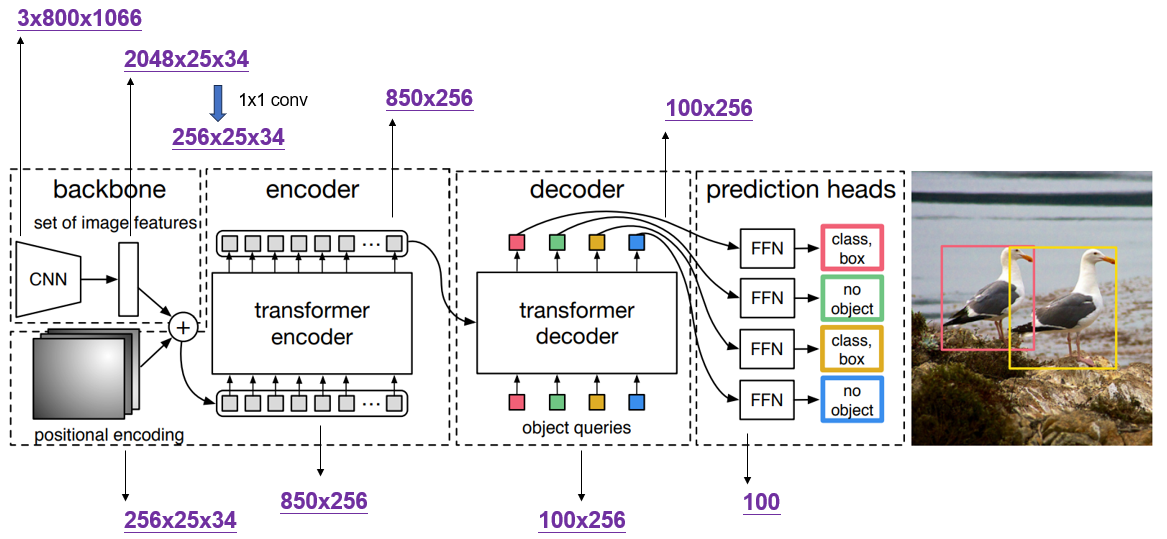

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

<a id="ref1"></a>
# <h3 align=center>Loss function </h3>


在DETR中，Loss function主要由兩部分組成：Bipartite matching和Hungarian algorithm

整體過程分為兩步：
1. 計算匈牙利匹配(Bipartite matching)，將Ground Truth與模型輸出匹配。
2. 計算匹配對之間的損失(Hungarian algorithm)。

分成這幾個部分介紹
<li><a id="L1">Bounding Box loss</a></li>
<li><a id="L2">Bipartite matching</a></li>
<li><a id="L3">Hungarian algorithm</a></li>

<a id="L1"></a>
### Bounding Box loss

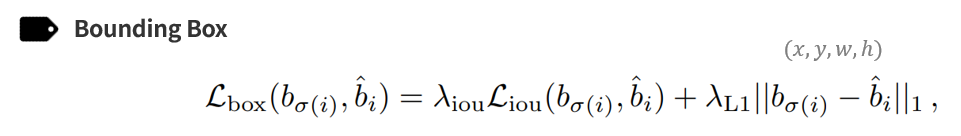

用於衡量模型預測的邊界框與真實邊界框之間的差異


- GIoU loss：用於衡量預測邊界框和真實邊界框之間的廣義交並比（Generalized Intersection over Union）。

參考 Generalized Intersection over Union: A Metric and A Loss for Bounding Box Regression https://arxiv.org/abs/1902.09630

In [26]:
from torchvision.ops.boxes import box_area
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)
# modified from torchvision to also return the union
def box_iou(boxes1, boxes2):
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    #左上
    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    #右下
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]
    #交集的高寬
    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    #交集的面積
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]
    #聯集的面積
    union = area1[:, None] + area2 - inter
    #交集/聯集
    iou = inter / union

    return iou, union

def generalized_box_iou(boxes1, boxes2):
    # degenerate boxes gives inf / nan results
    # so do an early check
    # 確保每個框的右下角大於左上角(一般來說BBOX都是從右下角畫到左上角)
    assert (boxes1[:, 2:] >= boxes1[:, :2]).all() 
    assert (boxes2[:, 2:] >= boxes2[:, :2]).all()

    # 計算 IoU 和聯集
    iou, union = box_iou(boxes1, boxes2)

    # 計算最小外接矩形的左上角 (lt) 和右下角 (rb)
    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])  # boxes1 與 boxes2 的左上角的最小值
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])  # boxes1 與 boxes2 的右下角的最大值

    # 計算最小外接矩形的寬高
    wh = (rb - lt).clamp(min=0)  # 取最大值與最小值的差，並將負數設為 0
    area = wh[:, :, 0] * wh[:, :, 1]  # 最小外接矩形的面積

    # 計算 GIoU
    return iou - (area - union) / area


測試範例

In [40]:
out_bbox = torch.tensor([
    [0.5, 0.5, 0.3, 0.4],  # 查詢框 1
    [0.7, 0.7, 0.2, 0.3],  # 查詢框 2
])

tgt_bbox = torch.tensor([
    [0.6, 0.6, 0.3, 0.4],  # 目標框 1
    [0.8, 0.8, 0.2, 0.3],  # 目標框 2
])

# 將這些框轉換為 (x_min, y_min, x_max, y_max) 格式
out_bbox_xyxy = box_cxcywh_to_xyxy(out_bbox)
tgt_bbox_xyxy = box_cxcywh_to_xyxy(tgt_bbox)

# 計算 GIoU
cost_giou = -generalized_box_iou(out_bbox_xyxy, tgt_bbox_xyxy)
cost_giou


tensor([[-0.2333,  0.4965],
        [-0.1679, -0.0333]])

- L1 loss：用於衡量預測邊界框和真實邊界框之間的絕對差異。

測試範例

In [39]:
#torch.cdist 是 PyTorch 中計算所有預測框與所有目標框之間的距離函數

out_bbox = torch.tensor([
    [0.5, 0.5, 1.0, 1.0],  # 預測框 1
    [0.6, 0.6, 0.9, 0.9]   # 預測框 2
])

tgt_bbox = torch.tensor([
    [0.5, 0.5, 1.0, 1.0],  # 目標框 1
    [0.4, 0.4, 1.1, 1.1]   # 目標框 2
])
cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)

cost_bbox 

tensor([[0.0000, 0.4000],
        [0.4000, 0.8000]])

<a id="L2"></a>
### Bipartite matching

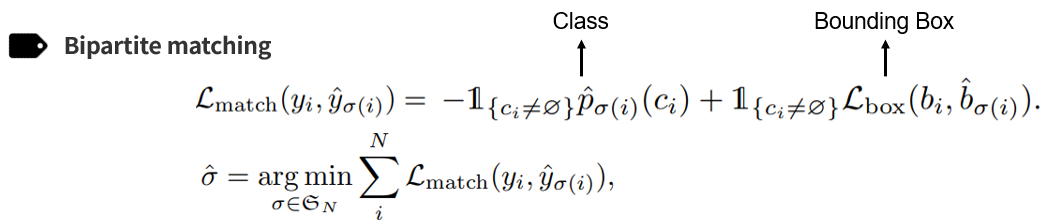

進行匈牙利算法的匹配，將模型的預測結果（queries）與目標（ground truths）進行一對一的最佳匹配


#### 參數

- `cost_class`: 類別的權重
- `cost_bbox`: bbox的權重
- `cost_giou`: giou的權重

- `outputs`: 模型預測結果dict
    - `pred_logits`: 類別預測分數，形狀為 `[batch_size, num_queries, num_classes]`
    - `pred_boxes`: 預測的bbox座標，形狀為 `[batch_size, num_queries, 4]`
- `targets`: Ground Truth dict
    - `labels`: Ground Truth的類別標籤，形狀為 `[num_target_boxes]`
    - `boxes`: Ground Truth的bbox座標，形狀為 `[num_target_boxes, 4]`



#### 返回值

**`(index_i, index_j)`**：列表
- `index_i`: 預測對的index
- `index_j`: 對應的類別標籤

In [56]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import torch
from scipy.optimize import linear_sum_assignment
from torch import nn


class HungarianMatcher(nn.Module):
    def __init__(self, cost_class: float = 1, cost_bbox: float = 1, cost_giou: float = 1):
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox 
        self.cost_giou = cost_giou 
        assert cost_class != 0 or cost_bbox != 0 or cost_giou != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        # [:2]取前兩個[batch_size, num_queries, num_classes] 存入bs, num_queries
        bs, num_queries = outputs["pred_logits"].shape[:2]
        # 展平預測的分數和bbox座標
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]
        print("out_prob shape:",out_prob.shape)
        print("out_bbox shape:",out_bbox.shape)


        # 結合不同batch的targets(補充)
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])
        print("tgt_ids shape:",tgt_ids.shape)
        print("tgt_bbox shape:",tgt_bbox.shape)
        print("------------------------------")
        # 計算類別的cost(補充)
        cost_class = -out_prob[:, tgt_ids]
        print("cost_class shape:",cost_class.shape)
        # 計算L1 cost
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)
        print("cost_bbox shape:",cost_bbox.shape)
        # 計算GIOU & bbox cost
        cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox), box_cxcywh_to_xyxy(tgt_bbox))
        print("cost_giou shape:",cost_giou.shape)
        print("------------------------------")
        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        # [batch_size * num_queries, num_classes] -> [batch_size, num_queries, num_classes] 要改成對單一張圖片
        C = C.view(bs, num_queries, -1).cpu() 
        print("矩陣 shape:",C.shape)

        # v["boxes"] 是每個 target 中的框，len(v["boxes"]) 就是這一張圖片中框的數量
        sizes = [len(v["boxes"]) for v in targets]
        # Hungarian Algorithm(補充)
        # 假設 C(2,100,5) sizes=[3,2] -> C.split(sizes, -1) -> c[0]=[2,100,3] , c[1]=[2,100,2]
        # linear_sum_assignment(c[0,1])就是再進一步把兩張圖片的cost矩陣進行匈牙利匹配
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))] 
        print("配對後的輸出",indices)
        print("------------------------------")
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]    
    
def build_matcher(args):
    return HungarianMatcher(cost_class=args.set_cost_class, cost_bbox=args.set_cost_bbox, cost_giou=args.set_cost_giou)

#### 補充

`tgt_ids`與`tgt_bbox`的具體意義

In [8]:
targets = [
    {"labels": torch.tensor([1, 2]), "boxes": torch.tensor([[0.1, 0.2, 0.5, 0.6], [0.3, 0.4, 0.7, 0.8]])},
    {"labels": torch.tensor([3]), "boxes": torch.tensor([[0.2, 0.3, 0.6, 0.7]])}
]
# 結合不同batch的targets
tgt_ids = torch.cat([v["labels"] for v in targets])
tgt_bbox = torch.cat([v["boxes"] for v in targets])
print("labels tensor：",tgt_ids,"\n","bbox tensor：",tgt_bbox)

labels tensor： tensor([1, 2, 3]) 
 bbox tensor： tensor([[0.1000, 0.2000, 0.5000, 0.6000],
        [0.3000, 0.4000, 0.7000, 0.8000],
        [0.2000, 0.3000, 0.6000, 0.7000]])


`cost_class`計算類別的cost

In [38]:
#假設有 2 個查詢和 3 個類別
out_prob = torch.tensor([
    [0.1, 0.7, 0.2],  # 第一個查詢的分類概率
    [0.3, 0.4, 0.3]   # 第二個查詢的分類概率
])

#目標類別標籤的索引
tgt_ids = torch.tensor([1, 2])  # 目標類別是第1類和第2類


# 取出預測的目標類別的分類概率
out_prob[:, tgt_ids]  

"""
以DETR來說就是100個query中對應的ground truth label
一張圖片是2個類別，假設是55(狗)和43(羊)
那麼out_prob就是100中個query中對應的第55和第43類的預測分數
"""

tensor([[0.7000, 0.2000],
        [0.4000, 0.3000]])

`linear_sum_assignment`匈牙利演算法函數

In [49]:
# SciPy 提供的一個實現匈牙利演算法（Hungarian Algorithm）的函數
from scipy.optimize import linear_sum_assignment
import numpy as np

"""範例一"""

# 成本矩陣 (3 workers x 3 tasks)
cost_matrix = np.array([
    [4, 1, 3],
    [2, 0, 5],
    [3, 2, 2]
])

# 匈牙利算法尋找最小成本分配
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# 結果
print("列索引（任務）：", row_ind)
print("行索引（工人）：", col_ind)

# 計算最小總成本
min_cost = cost_matrix[row_ind, col_ind].sum()
print("最小總成本：", min_cost)

"""範例二"""

# 假設有一個大矩陣被分割成多個子矩陣
C = torch.tensor([
    [4, 1, 3, 8],
    [2, 0, 5, 7],
    [3, 2, 2, 6],
    [9, 8, 4, 3]
], dtype=torch.float32)

# 每個子矩陣的大小
sizes = [2, 2]

# 按行分割 C，形成兩個子矩陣
sub_matrices = C.split(sizes, dim=-1)

print("-------------------------")
print("子矩陣 1：\n", sub_matrices[0])
print("子矩陣 2：\n", sub_matrices[1])

# 對每個子矩陣應用匈牙利算法
indices = [linear_sum_assignment(c.numpy()) for c in sub_matrices]

# 輸出結果
for i, (row_ind, col_ind) in enumerate(indices):
    print(f"子矩陣 {i+1} 的列索引（任務）：", row_ind)
    print(f"子矩陣 {i+1} 的行索引（工人）：", col_ind)


列索引（任務）： [0 1 2]
行索引（工人）： [1 0 2]
最小總成本： 5
-------------------------
子矩陣 1：
 tensor([[4., 1.],
        [2., 0.],
        [3., 2.],
        [9., 8.]])
子矩陣 2：
 tensor([[3., 8.],
        [5., 7.],
        [2., 6.],
        [4., 3.]])
子矩陣 1 的列索引（任務）： [0 1]
子矩陣 1 的行索引（工人）： [1 0]
子矩陣 2 的列索引（任務）： [2 3]
子矩陣 2 的行索引（工人）： [0 1]


#### 測試範例

In [63]:
# 假的輸出和目標數據
outputs = {
    "pred_logits": torch.rand(2, 100, 3),  # batch_size=2, num_queries=100, num_classes=3
    "pred_boxes": torch.rand(2, 100, 4),  # batch_size=2, num_queries=100, bbox格式(c_x, c_y, w, h)
}

targets = [
    {
        "labels": torch.tensor([0, 1]),  # 第一張圖片的兩個目標類別
        "boxes": torch.tensor([[0.1, 0.2, 0.4, 0.3], [0.5, 0.5, 0.3, 0.2]])  # bbox格式(c_x, c_y, w, h)
    },
    {
        "labels": torch.tensor([1, 2, 0]),  # 第二張圖片的三個目標類別
        "boxes": torch.tensor([[0.2, 0.3, 0.5, 0.4], [0.6, 0.7, 0.2, 0.1], [0.3, 0.2, 0.4, 0.3]])  # bbox
    }
]

In [59]:
# 實例化 HungarianMatcher 並進行匹配
matcher = HungarianMatcher(cost_class=1, cost_bbox=1, cost_giou=1)
indices = matcher(outputs, targets)

# 打印結果
for batch_idx, (src, tgt) in enumerate(indices):
    print(f"圖片{batch_idx+1}:")
    print(f"  100個預測中的: {src.tolist()}")
    print(f"  對應實際Ground Truth的類別: {tgt.tolist()}")

out_prob shape: torch.Size([200, 3])
out_bbox shape: torch.Size([200, 4])
tgt_ids shape: torch.Size([5])
tgt_bbox shape: torch.Size([5, 4])
------------------------------
cost_class shape: torch.Size([200, 5])
cost_bbox shape: torch.Size([200, 5])
cost_giou shape: torch.Size([200, 5])
------------------------------
矩陣 shape: torch.Size([2, 100, 5])
配對後的輸出 [(array([56, 77]), array([1, 0])), (array([23, 66, 91]), array([0, 2, 1]))]
------------------------------
圖片1:
  100個預測中的: [56, 77]
  對應實際Ground Truth的類別: [1, 0]
圖片2:
  100個預測中的: [23, 66, 91]
  對應實際Ground Truth的類別: [0, 2, 1]


<a id="L3"></a>
### Hungarian algorithm
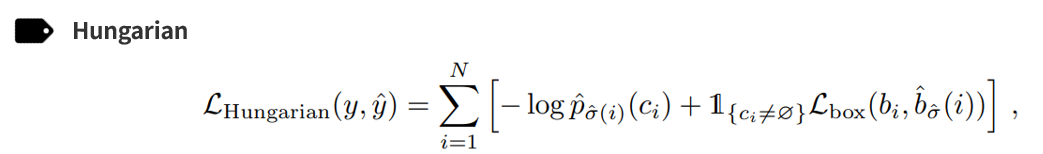


經由Bipartite matching我們已經找出最好的那一組配對，接下來就是計算loss，以更新模型參數


#### 參數

- `num_classes`: 類別總數（不包括 "no-object" 類別）
- `matcher`: HungarianMatcher的實例化
- `eos_coef`: 用於"no-object"類別的相對分類權重
- `losses`: 要應用的loss列表（如labels, boxes）
- `outputs`: 模型預測結果 dict
    - `pred_logits`: 類別預測分數，形狀為 `[batch_size, num_queries, num_classes]`
    - `pred_boxes`: 預測的bbox座標，形狀為 `[batch_size, num_queries, 4]`
- `targets`: Ground Truth dict
    - `labels`: Ground Truth的類別標籤，形狀為 `[num_target_boxes]`
    - `boxes`: Ground Truth的bbox座標，形狀為 `[num_target_boxes, 4]`

#### 返回值

- loss dict: 包含以下鍵值：
    - `loss_ce`: Cross Entropy loss
    - `loss_bbox`: L1 loss
    - `loss_giou`: GIoU loss

In [95]:
class SetCriterion(nn.Module):

    def __init__(self, num_classes, matcher, eos_coef, losses):
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.eos_coef = eos_coef
        self.losses = losses

        # 建立用於加權的tensor，對 "no-object" 類別賦值為 eos_coef
        empty_weight = torch.ones(self.num_classes + 1)  # 多一個"no-object"類別
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_boxes):#方便介紹 先去掉log運算
        # 確保輸出有'pred_logits'
        assert 'pred_logits' in outputs  
        # 預測類別的logits
        src_logits = outputs['pred_logits']  

        # 獲取匹配的index（模型輸出）
        idx = self._get_src_permutation_idx(indices)

        # 目標類別的index
        target_classes_o = torch.cat(
            [t["labels"][J] for t, (_, J) in zip(targets, indices)]
        )
        # 初始化與預測形狀一致的tensor，未分配的部分設為num_classes (no-object)
        target_classes = torch.full(
            src_logits.shape[:2], self.num_classes, dtype=torch.int64, device=src_logits.device
        )
        # 將匹配到的index賦值為實際的目標類別
        target_classes[idx] = target_classes_o

        # 計算交叉熵損失，並記錄到損失字典中
        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        # 確保輸出有'pred_boxes'
        assert 'pred_boxes' in outputs

        # 獲取匹配索引
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]  # 預測的bbox
        target_boxes = torch.cat(
            [t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0
        )

        # 計算L1損失
        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')
        losses = {'loss_bbox': loss_bbox.sum() / num_boxes}

        # 計算GIoU損失
        loss_giou = 1 - torch.diag(
            generalized_box_iou(box_cxcywh_to_xyxy(src_boxes), box_cxcywh_to_xyxy(target_boxes))
        )
        losses['loss_giou'] = loss_giou.sum() / num_boxes

        return losses

    def _get_src_permutation_idx(self, indices):

        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        #模型輸出的索引
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx
    
    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'boxes': self.loss_boxes,
        }
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets):

        # 計算匈牙利匹配索引
        indices = self.matcher(outputs, targets)

        # 計算平均的目標框數量
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor(
            [num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device
        )

        # 逐一計算所有指定的loss()
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        return losses , indices


#### 測試範例

In [186]:
import torch
import torch.nn.functional as F
from torch import nn

# 假資料的生成
num_classes = 3  # 類別數（不包含 "no-object"）
batch_size = 2  # 批次大小
num_queries = 100  # 每個輸入的預測數量

# 模擬模型的輸出
outputs = {
    'pred_logits': torch.randn(batch_size, num_queries, num_classes + 1),  # 預測的類別分數
    'pred_boxes': torch.rand(batch_size, num_queries, 4)  # 預測的bbox (cx, cy, w, h)
}

# 模擬 總共3個Object
targets = [
    {
        'labels': torch.tensor([0 , 2], dtype=torch.int64),  # 類別標籤
        'boxes': torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.2, 0.2]], dtype=torch.float32)  # bbox
    },
    {
        'labels': torch.tensor([1], dtype=torch.int64),
        'boxes': torch.tensor([[0.4, 0.3, 0.1, 0.1]], dtype=torch.float32)
    }
]

# 初始化 SetCriterion
matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)
losses = ['labels', 'boxes']

criterion = SetCriterion(num_classes, matcher, eos_coef=0.1, losses=losses)

# 計算損失
losses , indices = criterion(outputs, targets)

# 結果
for batch_idx, (src, tgt) in enumerate(indices):
    print(f"圖片{batch_idx+1}:")
    print(f"  100個預測中的: {src.tolist()}")
    print(f"  對應實際Ground Truth的類別: {tgt.tolist()}")
    
print("------------------------------")
# 輸出loss結果
print("最終loss值:")
for key, value in losses.items():
    print(f"{key}: {value.item()}")



out_prob shape: torch.Size([200, 4])
out_bbox shape: torch.Size([200, 4])
tgt_ids shape: torch.Size([3])
tgt_bbox shape: torch.Size([3, 4])
------------------------------
cost_class shape: torch.Size([200, 3])
cost_bbox shape: torch.Size([200, 3])
cost_giou shape: torch.Size([200, 3])
------------------------------
矩陣 shape: torch.Size([2, 100, 3])
配對後的輸出 [(array([15, 92]), array([0, 1])), (array([46]), array([0]))]
------------------------------
圖片1:
  100個預測中的: [15, 92]
  對應實際Ground Truth的類別: [0, 1]
圖片2:
  100個預測中的: [46]
  對應實際Ground Truth的類別: [0]
------------------------------
最終loss值:
loss_ce: 1.716863989830017
loss_bbox: 0.4206918776035309
loss_giou: 0.9526950716972351


<a id="ref2"></a>
# <h3 align=center>輸出頭 </h3>

在DETR中，輸出頭分為兩個主要部分：`MLP`和`PostProcess`

分成這兩個部分介紹
<li><a id="m1">MLP</a></li>
<li><a id="m2">PostProcess</a></li>

<a id="m1"></a>
### MLP

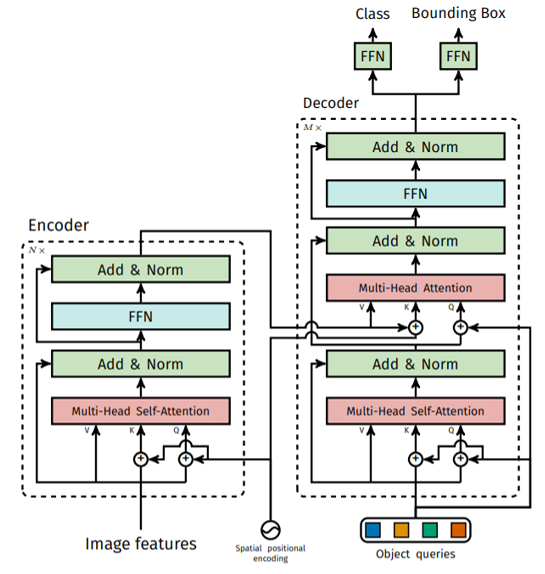

定義了一個簡單的多層感知器（MLP），主要功能是將輸入的特徵映射到邊界框的預測坐標


#### 參數

- `input_dim`: 輸入的特徵維度
- `hidden_dim`: 隱藏層的維度
- `output_dim`: 輸出的維度，對於邊界框預測是 4
- `num_layers`: MLP 的層數

#### 返回值

- `x`: 邊界框的預測坐標`（cx, cy, w, h）`

In [206]:
class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers): # output_dim是4 對應於預測的邊界框座標 [cx, cy, w, h]
        super().__init__()
        self.num_layers = num_layers # MLP 的深度
        # 創建了一個長度為 num_layers - 1 的列表
        h = [hidden_dim] * (num_layers - 1) # h: [hidden_dim, hidden_dim]
        # zip([input_dim] + h, h + [output_dim]) -> [256, 512, 512],[512, 512, 4] ->(256, 512)、(512, 512)、(512, 4)
        # 等同於 nn.Linear(256, 512)、nn.Linear(512, 512)、nn.Linear(512, 4)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers): # index , nn.Linear
            # 每一層都使用ReLU激活函數（最後一層除外）
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x

#### 測試案例

In [212]:
import torch

# 假設的參數
batch_size = 2
num_queries = 100
hidden_dim = 256

# 模擬Transformer的輸出
hs = torch.randn(batch_size, num_queries, hidden_dim)  # 隨機生成假資料

# 假設 MLP 層
bbox_embed = MLP(256, 256, 4, 3)

# 將 hs 傳入 MLP 層，並應用 sigmoid 激活函數
outputs_coord = bbox_embed(hs).sigmoid()

# 應該輸出 (batch_size, num_queries, 4)，即 (2, 100, 4)
print("經過MLP輸出頭的shape：\n",outputs_coord.shape)
print("經過MLP輸出頭的Bounding Box：\n",outputs_coord[0][0]) #第一筆資料

經過MLP輸出頭的shape：
 torch.Size([2, 100, 4])
經過MLP輸出頭的Bounding Box：
 tensor([0.4797, 0.4667, 0.4925, 0.4629], grad_fn=<SelectBackward0>)


<a id="m2"></a>
### PostProcess

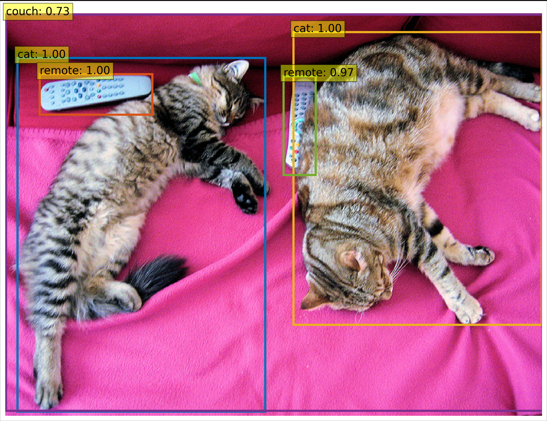

負責將模型最後的輸出`outputs['pred_logits']、outputs['pred_boxes']`轉換成適合視覺化的格式 -->`scores`, `labels`, `boxes`


#### 參數

- `outputs`: dict
    - `outputs['pred_logits']` 是模型的類別分數
    - `outputs['pred_boxes']` 是邊界框的預測座標。

- `target_sizes`: tensor of shape `[batch_size, 2]`
    - 每張圖片的尺寸，包含高與寬。這些尺寸會用來將相對座標（[0, 1]）轉換為絕對座標。

#### 返回值

- `results`: list of dicts
    - 每個元素是包含`'scores'`, `'labels'`, 和 `'boxes'`的字典，表示每張圖片的預測結果。
    - `scores`: tensor of shape `[num_queries]`, 表示每個預測的分數。
    - `labels`: tensor of shape `[num_queries]`, 表示每個預測的類別。
    - `boxes`: tensor of shape `[num_queries, 4]`, 表示每個預測的邊界框座標。


In [192]:
class PostProcess(nn.Module):
    
    @torch.no_grad()  # 禁用梯度計算，因為這部分是後處理過程，不需要反向傳播
    def forward(self, outputs, target_sizes):

        # 從輸出中提取預測的logits和邊界框
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        # 檢查logits的數量與目標大小是否一致
        assert len(out_logits) == len(target_sizes)
        # 檢查目標大小的維度是否為2（即高和寬）
        assert target_sizes.shape[1] == 2

        # 計算每個預測的類別分數（使用softmax函數將logits轉換為機率）
        prob = F.softmax(out_logits, -1)
        # 取出最大概率對應的分數和類別
        scores, labels = prob[..., :-1].max(-1) #移除 softmax 結果中的最後一個類別（通常是背景或無物體類別）。

        # 將預測的邊界框格式從 [cx, cy, w, h] 轉換為 [x0, y0, x1, y1] 形式
        boxes = box_cxcywh_to_xyxy(out_bbox)
        # 將相對座標 [0, 1] 轉換為絕對座標 [0, height] 和 [0, width]（乘以圖像的寬高）
        img_h, img_w = target_sizes.unbind(1)  # 將 target_sizes 分離成高度和寬度
        # 建立一個尺度因子，這會用來調整邊界框的座標
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        # 根據圖像的大小縮放邊界框
        boxes = boxes * scale_fct[:, None, :]

        # 將每張圖片的預測結果（包括分數、標籤和邊界框）包裝為字典
        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        # 返回每張圖片的預測結果
        return results


#### 測試案例

In [193]:
import torch
import torch.nn.functional as F

# 假資料
outputs = {
    'pred_logits': torch.tensor([[[1.2, 0.3, 0.1], [0.7, 1.1, 0.3], [0.5, 0.6, 1.2]],  # 第一張圖
                                [[0.4, 1.0, 0.8], [0.2, 0.9, 1.5], [1.0, 0.4, 0.7]]]),  # 第二張圖
    'pred_boxes': torch.tensor([[[0.5, 0.5, 0.4, 0.3], [0.6, 0.4, 0.3, 0.2], [0.3, 0.7, 0.2, 0.4]],  # 第一張圖
                               [[0.2, 0.2, 0.5, 0.6], [0.4, 0.5, 0.4, 0.3], [0.3, 0.8, 0.3, 0.5]]])  # 第二張圖
}

target_sizes = torch.tensor([[256, 256], [512, 512]])  # 圖像大小，第一張 256x256，第二張 512x512

# 創建PostProcess實例
post_process = PostProcess()

# 測試前向傳遞
results = post_process(outputs, target_sizes)

# 打印結果
for i, result in enumerate(results):
    print(f"結果 {i+1}:")
    print(f"  分數: {result['scores']}")
    print(f"  標籤: {result['labels']}")
    print(f"  邊界框: {result['boxes']}")


結果 1:
  分數: tensor([0.5749, 0.4718, 0.2683])
  標籤: tensor([0, 1, 1])
  邊界框: tensor([[ 76.8000,  89.6000, 179.2000, 166.4000],
        [115.2000,  76.8000, 192.0000, 128.0000],
        [ 51.2000, 128.0000, 102.4000, 230.4000]])
結果 2:
  分數: tensor([0.4224, 0.3013, 0.4368])
  標籤: tensor([1, 1, 0])
  邊界框: tensor([[-25.6000, -51.2000, 230.4000, 256.0000],
        [102.4000, 179.2000, 307.2000, 332.8000],
        [ 76.8000, 281.6000, 230.4000, 537.6000]])
